Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading preprocessed data from .npy files...
Data loaded successfully.
PyTorch DataLoaders created.
Loading model: distilbert-base-uncased
Using device: cuda
Total Trainable Parameters: 66,955,010
Starting model training with early stopping...


Epoch 1/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 Summary: Avg Train Loss: 0.2994, Avg Val Loss: 0.1613, Time: 38.64s


Epoch 2/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 Summary: Avg Train Loss: 0.0831, Avg Val Loss: 0.3412, Time: 42.30s
Loaded best model weights for final evaluation.

Evaluating model on the test set...


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


--- Final Results ---
              precision    recall  f1-score   support

       Human       0.99      0.76      0.86       476
          AI       0.82      0.99      0.90       524

    accuracy                           0.88      1000
   macro avg       0.91      0.88      0.88      1000
weighted avg       0.90      0.88      0.88      1000


--- Confusion Matrix ---


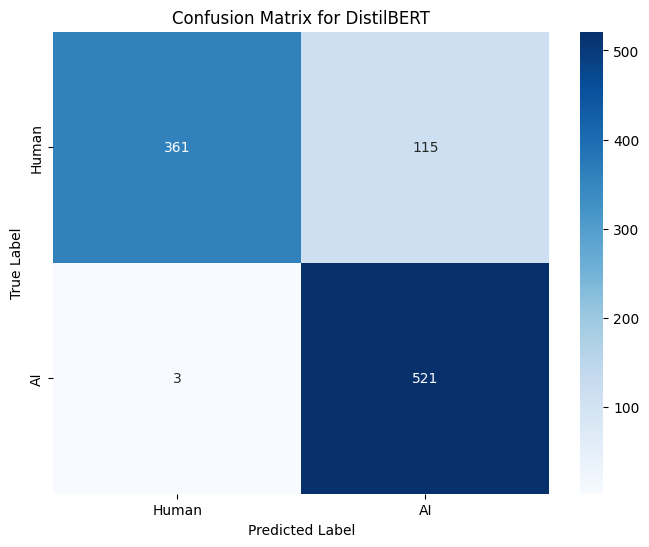

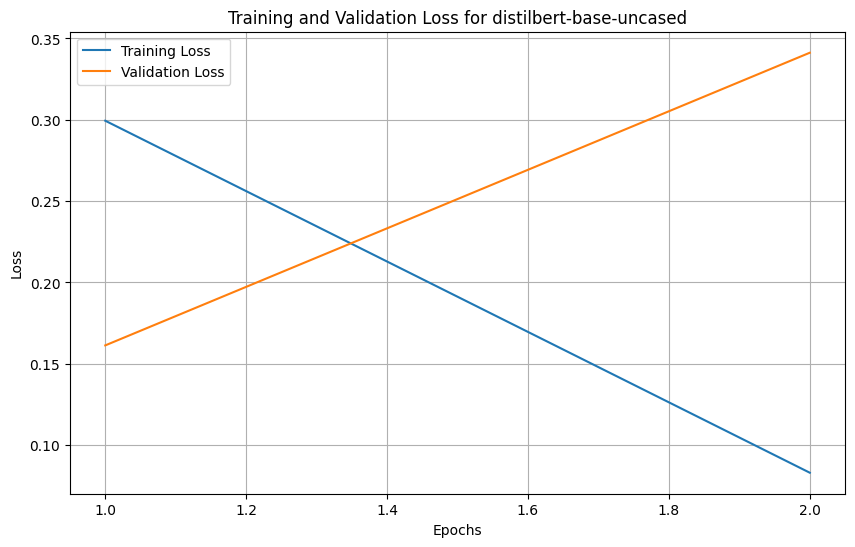

In [ ]:
# --- 1. Installation ---
import sys
!{sys.executable} -m pip install torch transformers scikit-learn pandas tqdm accelerate matplotlib seaborn sentencepiece

# --- 2. Imports ---
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Configuration ---
MODEL_NAME = 'distilbert-base-uncased'
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5

# --- 4. Load Preprocessed Data ---
print("Loading preprocessed data from .npy files...")
try:
    X_train = np.load('X_train_5k.npy')
    train_masks = np.load('train_masks_5k.npy')
    y_train = np.load('y_train_5k.npy')
    X_val = np.load('X_val_5k.npy')
    val_masks = np.load('val_masks_5k.npy')
    y_val = np.load('y_val_5k.npy')
    X_test = np.load('X_test_5k.npy')
    test_masks = np.load('test_masks_5k.npy')
    y_test = np.load('y_test_5k.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure all nine '_5k.npy' files are in the same directory.")

# --- 5. Create PyTorch Tensors and DataLoaders ---
X_train_t = torch.tensor(X_train)
train_masks_t = torch.tensor(train_masks)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val)
val_masks_t = torch.tensor(val_masks)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test)
test_masks_t = torch.tensor(test_masks)
y_test_t = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_t, train_masks_t, y_train_t)
val_dataset = TensorDataset(X_val_t, val_masks_t, y_val_t)
test_dataset = TensorDataset(X_test_t, test_masks_t, y_test_t)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
print("PyTorch DataLoaders created.")

# --- 6. Build and Train the Model ---
print(f"Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
patience = 2
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
history = {'train_loss': [], 'val_loss': []}

print("Starting model training with early stopping...")
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Training]")
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    avg_train_loss = total_train_loss / len(train_dataloader)
    history['train_loss'].append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validation]"):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    history['val_loss'].append(avg_val_loss)
    duration = time.time() - start_time
    print(f"Epoch {epoch + 1} Summary: Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Time: {duration:.2f}s")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights for final evaluation.")

# --- 7. Evaluate the Model ---
print("\nEvaluating model on the test set...")
model.eval()
all_preds = []
all_true = []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
    all_preds.extend(preds)
    all_true.extend(b_labels.detach().cpu().numpy())

print("\n--- Final Results ---")
target_names = ['Human', 'AI']
print(classification_report(all_true, all_preds, target_names=target_names))
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for DistilBERT')
plt.show()

# --- 8. Plot Training and Validation Loss ---
epochs_ran = len(history['train_loss'])
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_ran + 1), history['train_loss'], label='Training Loss')
plt.plot(range(1, epochs_ran + 1), history['val_loss'], label='Validation Loss')
plt.title(f'Training and Validation Loss for {MODEL_NAME}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Loading preprocessed data from .npy files...
Data loaded successfully.
PyTorch DataLoaders created.
Loading model: roberta-base


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Total Trainable Parameters: 124,647,170
Starting model training with early stopping...


Epoch 1/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 Summary: Avg Train Loss: 0.6953, Avg Val Loss: 0.6932, Time: 84.71s


Epoch 2/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 Summary: Avg Train Loss: 0.6973, Avg Val Loss: 0.6930, Time: 84.05s
Loaded best model weights for final evaluation.

Evaluating model on the test set...


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


--- Final Results ---
              precision    recall  f1-score   support

       Human       0.48      1.00      0.64       476
          AI       0.00      0.00      0.00       524

    accuracy                           0.48      1000
   macro avg       0.24      0.50      0.32      1000
weighted avg       0.23      0.48      0.31      1000


--- Confusion Matrix ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


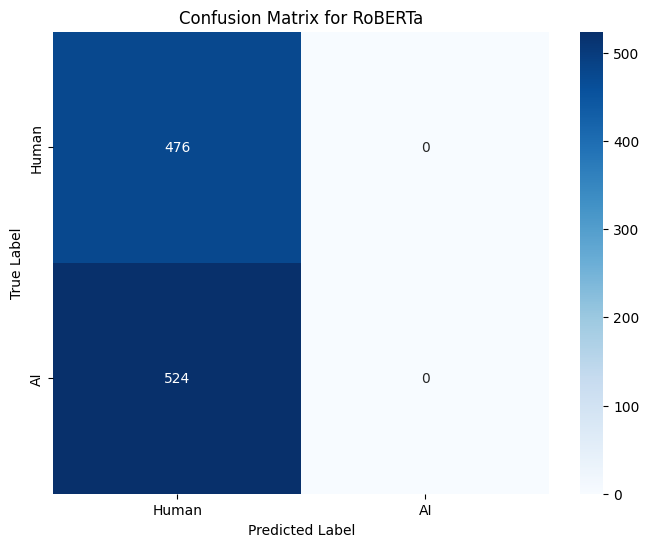

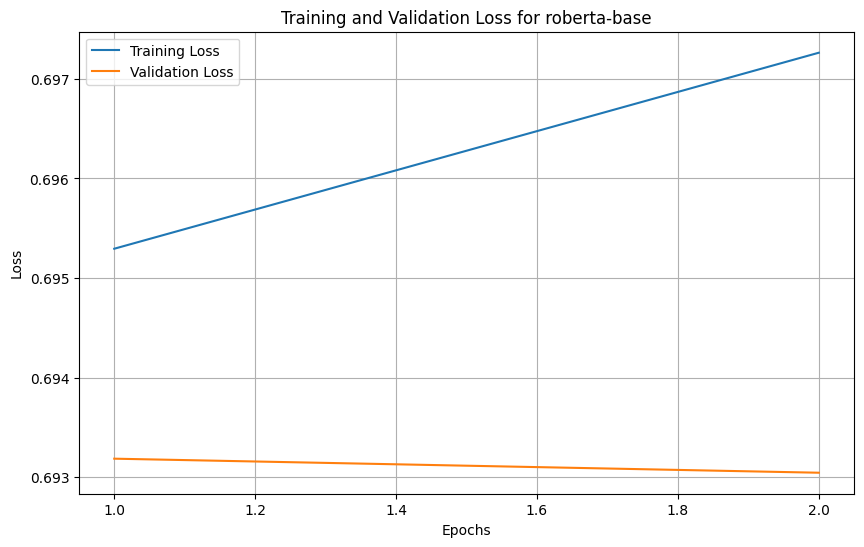

In [ ]:
# --- 1. Installation ---
import sys
!{sys.executable} -m pip install torch transformers scikit-learn pandas tqdm accelerate matplotlib seaborn sentencepiece

# --- 2. Imports ---
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Configuration ---
MODEL_NAME = 'roberta-base'
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5

# --- 4. Load Preprocessed Data ---
print("Loading preprocessed data from .npy files...")
try:
    X_train = np.load('X_train_5k.npy')
    train_masks = np.load('train_masks_5k.npy')
    y_train = np.load('y_train_5k.npy')
    X_val = np.load('X_val_5k.npy')
    val_masks = np.load('val_masks_5k.npy')
    y_val = np.load('y_val_5k.npy')
    X_test = np.load('X_test_5k.npy')
    test_masks = np.load('test_masks_5k.npy')
    y_test = np.load('y_test_5k.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure all nine '_5k.npy' files are in the same directory.")

# --- 5. Create PyTorch Tensors and DataLoaders ---
X_train_t = torch.tensor(X_train)
train_masks_t = torch.tensor(train_masks)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val)
val_masks_t = torch.tensor(val_masks)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test)
test_masks_t = torch.tensor(test_masks)
y_test_t = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_t, train_masks_t, y_train_t)
val_dataset = TensorDataset(X_val_t, val_masks_t, y_val_t)
test_dataset = TensorDataset(X_test_t, test_masks_t, y_test_t)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
print("PyTorch DataLoaders created.")

# --- 6. Build and Train the Model ---
print(f"Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
patience = 2
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
history = {'train_loss': [], 'val_loss': []}

print("Starting model training with early stopping...")
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Training]")
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    avg_train_loss = total_train_loss / len(train_dataloader)
    history['train_loss'].append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validation]"):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    history['val_loss'].append(avg_val_loss)
    duration = time.time() - start_time
    print(f"Epoch {epoch + 1} Summary: Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Time: {duration:.2f}s")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights for final evaluation.")

# --- 7. Evaluate the Model ---
print("\nEvaluating model on the test set...")
model.eval()
all_preds = []
all_true = []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
    all_preds.extend(preds)
    all_true.extend(b_labels.detach().cpu().numpy())

print("\n--- Final Results ---")
target_names = ['Human', 'AI']
print(classification_report(all_true, all_preds, target_names=target_names))
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RoBERTa')
plt.show()

# --- 8. Plot Training and Validation Loss ---
epochs_ran = len(history['train_loss'])
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_ran + 1), history['train_loss'], label='Training Loss')
plt.plot(range(1, epochs_ran + 1), history['val_loss'], label='Validation Loss')
plt.title(f'Training and Validation Loss for {MODEL_NAME}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Loading preprocessed data from .npy files...
Data loaded successfully.
PyTorch DataLoaders created.
Loading model: google/electra-base-discriminator


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Total Trainable Parameters: 109,483,778
Starting model training with early stopping...


Epoch 1/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 Summary: Avg Train Loss: 0.2276, Avg Val Loss: 0.0829, Time: 86.83s


Epoch 2/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 Summary: Avg Train Loss: 0.0533, Avg Val Loss: 0.0338, Time: 86.83s
Loaded best model weights for final evaluation.

Evaluating model on the test set...


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


--- Final Results ---
              precision    recall  f1-score   support

       Human       0.98      0.98      0.98       476
          AI       0.98      0.98      0.98       524

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


--- Confusion Matrix ---


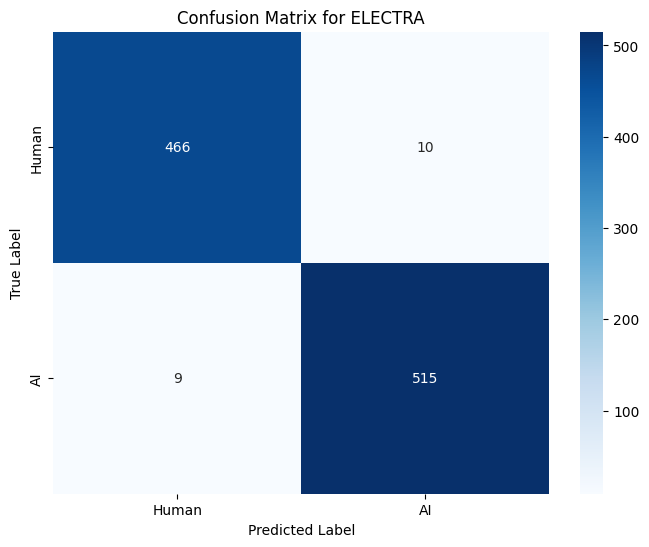

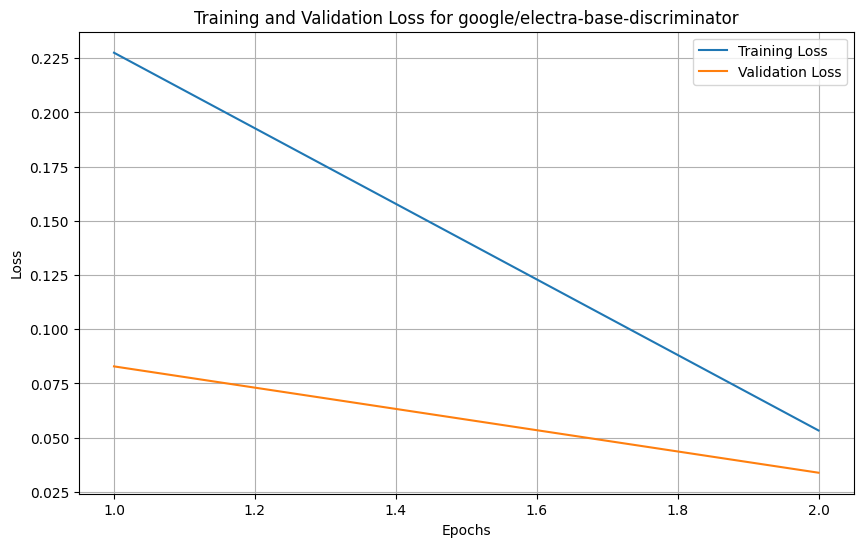

In [ ]:
# --- 1. Installation ---
import sys
!{sys.executable} -m pip install torch transformers scikit-learn pandas tqdm accelerate matplotlib seaborn sentencepiece

# --- 2. Imports ---
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Configuration ---
MODEL_NAME = 'google/electra-base-discriminator'
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5

# --- 4. Load Preprocessed Data ---
print("Loading preprocessed data from .npy files...")
try:
    X_train = np.load('X_train_5k.npy')
    train_masks = np.load('train_masks_5k.npy')
    y_train = np.load('y_train_5k.npy')
    X_val = np.load('X_val_5k.npy')
    val_masks = np.load('val_masks_5k.npy')
    y_val = np.load('y_val_5k.npy')
    X_test = np.load('X_test_5k.npy')
    test_masks = np.load('test_masks_5k.npy')
    y_test = np.load('y_test_5k.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure all nine '_5k.npy' files are in the same directory.")

# --- 5. Create PyTorch Tensors and DataLoaders ---
X_train_t = torch.tensor(X_train)
train_masks_t = torch.tensor(train_masks)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val)
val_masks_t = torch.tensor(val_masks)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test)
test_masks_t = torch.tensor(test_masks)
y_test_t = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_t, train_masks_t, y_train_t)
val_dataset = TensorDataset(X_val_t, val_masks_t, y_val_t)
test_dataset = TensorDataset(X_test_t, test_masks_t, y_test_t)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
print("PyTorch DataLoaders created.")

# --- 6. Build and Train the Model ---
print(f"Loading model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
patience = 2
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
history = {'train_loss': [], 'val_loss': []}

print("Starting model training with early stopping...")
for epoch in range(EPOCHS):
    start_time = time.time()
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Training]")
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    avg_train_loss = total_train_loss / len(train_dataloader)
    history['train_loss'].append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validation]"):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    history['val_loss'].append(avg_val_loss)
    duration = time.time() - start_time
    print(f"Epoch {epoch + 1} Summary: Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Time: {duration:.2f}s")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights for final evaluation.")

# --- 7. Evaluate the Model ---
print("\nEvaluating model on the test set...")
model.eval()
all_preds = []
all_true = []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
    all_preds.extend(preds)
    all_true.extend(b_labels.detach().cpu().numpy())

print("\n--- Final Results ---")
target_names = ['Human', 'AI']
print(classification_report(all_true, all_preds, target_names=target_names))
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for ELECTRA')
plt.show()

# --- 8. Plot Training and Validation Loss ---
epochs_ran = len(history['train_loss'])
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_ran + 1), history['train_loss'], label='Training Loss')
plt.plot(range(1, epochs_ran + 1), history['val_loss'], label='Validation Loss')
plt.title(f'Training and Validation Loss for {MODEL_NAME}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Loading original CSV data...
Data loaded successfully.

Starting experiment for: xlnet-base-cased
Using tokenizer: XLNetTokenizer


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Trainable Parameters: 117,310,466
Starting model training...


Epoch 1/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 Summary: Avg Train Loss: 0.2444, Avg Val Loss: 0.1945, Time: 104.64s


Epoch 2/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 Summary: Avg Train Loss: 0.0610, Avg Val Loss: 0.0671, Time: 102.71s
Loaded best model weights for final evaluation.

Evaluating model on the test set...


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


--- Final Results ---
              precision    recall  f1-score   support

       Human       1.00      0.95      0.97       476
          AI       0.96      1.00      0.98       524

    accuracy                           0.98      1000
   macro avg       0.98      0.97      0.98      1000
weighted avg       0.98      0.98      0.98      1000


--- Confusion Matrix ---


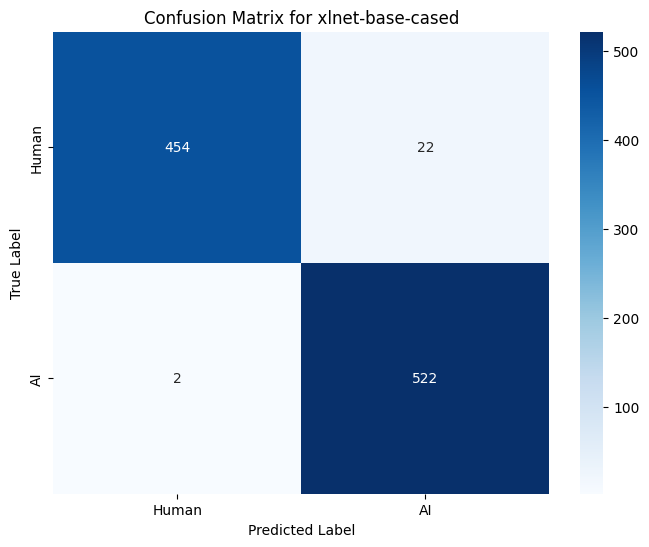

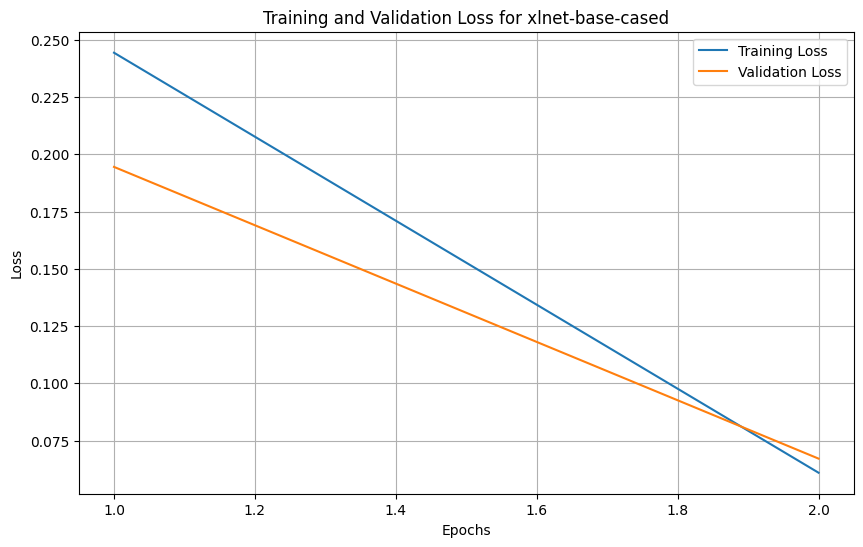


Starting experiment for: albert-base-v2
Using tokenizer: AlbertTokenizer


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total Trainable Parameters: 11,685,122
Starting model training...


Epoch 1/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 Summary: Avg Train Loss: 0.2374, Avg Val Loss: 0.0894, Time: 86.30s


Epoch 2/2 [Training]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2/2 [Validation]:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 Summary: Avg Train Loss: 0.0666, Avg Val Loss: 0.0504, Time: 85.67s
Loaded best model weights for final evaluation.

Evaluating model on the test set...


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


--- Final Results ---
              precision    recall  f1-score   support

       Human       0.98      0.99      0.98       476
          AI       0.99      0.98      0.98       524

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


--- Confusion Matrix ---


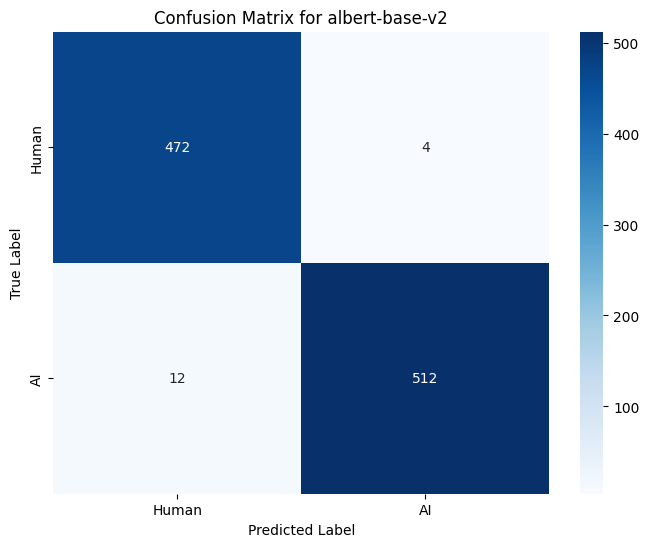

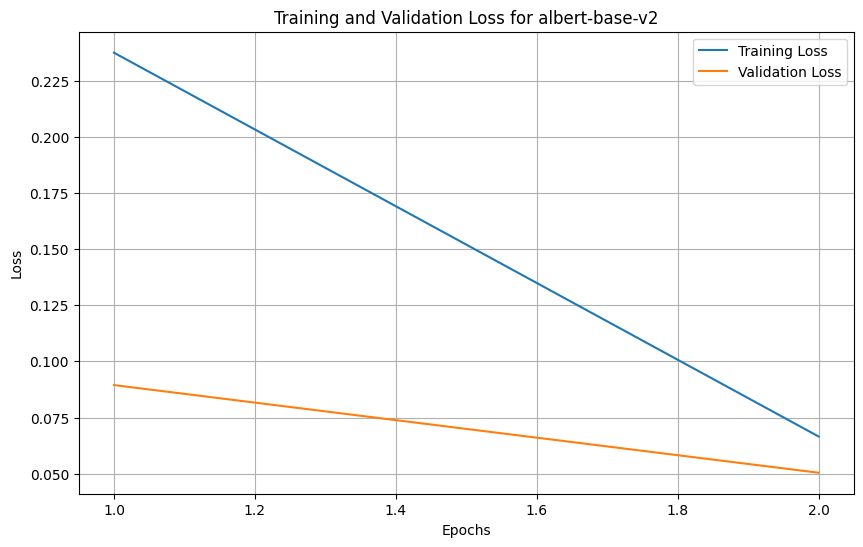


Final Experiment Summary
Model: xlnet-base-cased
  - Accuracy: 0.9760
  - Macro F1-Score: 0.9759
Model: albert-base-v2
  - Accuracy: 0.9840
  - Macro F1-Score: 0.9840


In [ ]:
# --- 1. Installation ---
#import sys
#!{sys.executable} -m pip install torch transformers scikit-learn pandas tqdm accelerate matplotlib seaborn sentencepiece

# --- 2. Imports ---
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AlbertTokenizer, XLNetTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# --- 3. Configuration ---
MODELS_TO_TRAIN = ['xlnet-base-cased', 'albert-base-v2']
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5

# --- 4. Reusable Training and Evaluation Function ---
def train_and_evaluate(model_name, texts, labels):
    print("\n" + "="*50)
    print(f"Starting experiment for: {model_name}")
    print("="*50)

    # Step A: Choose the Correct Tokenizer for each model
    if 'albert' in model_name:
        tokenizer = AlbertTokenizer.from_pretrained(model_name)
    elif 'xlnet' in model_name:
        tokenizer = XLNetTokenizer.from_pretrained(model_name)
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    print(f"Using tokenizer: {tokenizer.__class__.__name__}")

    # Step B: Split and Tokenize Data inside the function
    train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
    train_texts, val_texts, train_labels, val_labels = train_test_split(train_val_texts, train_val_labels, test_size=0.25, random_state=42)

    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

    # Step C: Create DataLoaders
    X_train_t = torch.tensor(train_encodings['input_ids'])
    train_masks_t = torch.tensor(train_encodings['attention_mask'])
    y_train_t = torch.tensor(train_labels, dtype=torch.long)

    X_val_t = torch.tensor(val_encodings['input_ids'])
    val_masks_t = torch.tensor(val_encodings['attention_mask'])
    y_val_t = torch.tensor(val_labels, dtype=torch.long)

    X_test_t = torch.tensor(test_encodings['input_ids'])
    test_masks_t = torch.tensor(test_encodings['attention_mask'])
    y_test_t = torch.tensor(test_labels, dtype=torch.long)

    train_dataset = TensorDataset(X_train_t, train_masks_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, val_masks_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, test_masks_t, y_test_t)

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Build the Model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {total_params:,}")
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

    patience = 2
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    history = {'train_loss': [], 'val_loss': []}

    print("Starting model training...")
    for epoch in range(EPOCHS):
        start_time = time.time()
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Training]")
        for batch in progress_bar:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validation]"):
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        duration = time.time() - start_time
        print(f"Epoch {epoch + 1} Summary: Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}, Time: {duration:.2f}s")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model weights for final evaluation.")

    # Evaluate the Model
    print("\nEvaluating model on the test set...")
    model.eval()
    all_preds = []
    all_true = []
    for batch in tqdm(test_loader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
        all_preds.extend(preds)
        all_true.extend(b_labels.detach().cpu().numpy())

    # Print Final Results
    print("\n--- Final Results ---")
    target_names = ['Human', 'AI']
    print(classification_report(all_true, all_preds, target_names=target_names))

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_true, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    epochs_ran = len(history['train_loss'])
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs_ran + 1), history['train_loss'], label='Training Loss')
    plt.plot(range(1, epochs_ran + 1), history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return key metrics for the final summary
    return {
        'accuracy': accuracy_score(all_true, all_preds),
        'f1_score_macro': f1_score(all_true, all_preds, average='macro')
    }

# --- 5. Load Data and Run Experiments ---
print("Loading original CSV data...")
try:
    df = pd.read_csv('AI_Human_5k_balanced.xls')
    texts = df['text'].tolist()
    labels = df['generated'].tolist()
    print("Data loaded successfully.")

    final_results = {}
    for name in MODELS_TO_TRAIN:
        results = train_and_evaluate(name, texts, labels)
        final_results[name] = results

    # --- 6. Print Final Summary ---
    print("\n" + "="*50)
    print("Final Experiment Summary")
    print("="*50)
    for model_name, metrics in final_results.items():
        print(f"Model: {model_name}")
        print(f"  - Accuracy: {metrics['accuracy']:.4f}")
        print(f"  - Macro F1-Score: {metrics['f1_score_macro']:.4f}")
    print("="*50)

except FileNotFoundError:
    print("Error: Make sure 'AI_Human_5k_balanced.csv' is in the same directory.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Loading 'AI_Human_5k_balanced.xls'...
Creating data splits...
Loading NLP models for parsing and feature extraction...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Models loaded.
Converting texts to graphs...


Test Graphs: 100%|██████████| 1000/1000 [1:02:31<00:00,  3.75s/it]


Graph conversion complete.
Graph DataLoaders created.
GCN model defined.
Total Trainable Parameters: 53,570
Starting GCN training...
Epoch: 01, Train Loss: 0.6773, Val Loss: 0.1521, Val Acc: 0.9510, Time: 33.74s
Epoch: 02, Train Loss: 0.1192, Val Loss: 0.0748, Val Acc: 0.9690, Time: 25.25s
Epoch: 03, Train Loss: 0.0804, Val Loss: 0.0557, Val Acc: 0.9780, Time: 26.00s
Epoch: 04, Train Loss: 0.0623, Val Loss: 0.0468, Val Acc: 0.9780, Time: 25.46s
Epoch: 05, Train Loss: 0.0499, Val Loss: 0.0628, Val Acc: 0.9790, Time: 25.05s
Epoch: 06, Train Loss: 0.0493, Val Loss: 0.0502, Val Acc: 0.9820, Time: 25.33s
Epoch: 07, Train Loss: 0.0546, Val Loss: 0.0734, Val Acc: 0.9780, Time: 25.21s
Early stopping triggered after 7 epochs.
Loaded best model weights for final evaluation.

Evaluating model on the final test set...
Final Test Accuracy: 0.9750

Generating classification report...
              precision    recall  f1-score   support

       Human       0.98      0.96      0.97       476
        

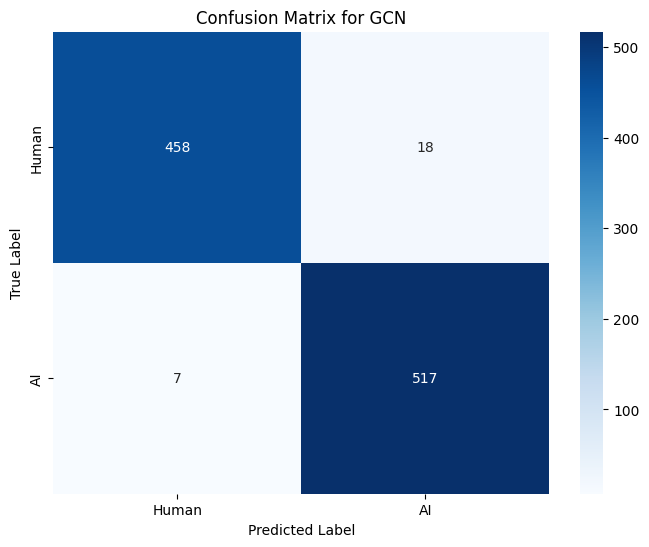

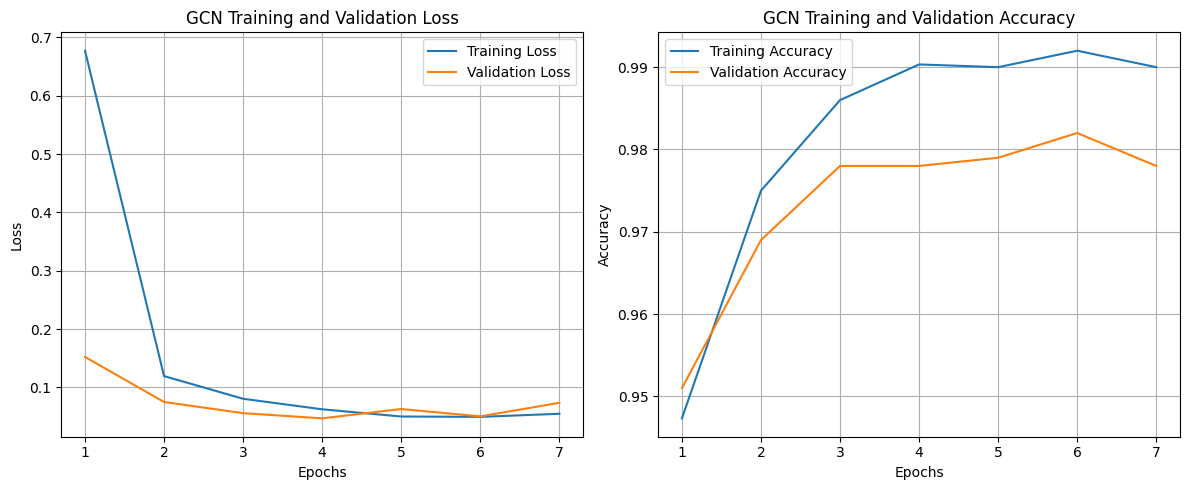

In [2]:
# --- 1. Installation ---
import sys
!{sys.executable} -m pip install torch torchvision torchaudio torch_geometric transformers scikit-learn pandas tqdm spacy matplotlib seaborn
!{sys.executable} -m spacy download en_core_web_sm

# --- 2. Imports ---
import pandas as pd
import numpy as np
import os
import spacy
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Configuration ---
FILE_NAME = 'AI_Human_5k_balanced.xls'
TEXT_COLUMN = 'text'
LABEL_COLUMN = 'generated'
RANDOM_STATE = 42
EPOCHS = 10
LEARNING_RATE = 0.01

# --- 4. Load and Split Dataset ---
print(f"Loading '{FILE_NAME}'...")
df = pd.read_csv(FILE_NAME)
print("Creating data splits...")
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=RANDOM_STATE)

# --- 5. Graph Construction Module ---
print("Loading NLP models for parsing and feature extraction...")
nlp = spacy.load("en_core_web_sm")
feature_model_name = 'distilgpt2'
feature_tokenizer = AutoTokenizer.from_pretrained(feature_model_name)
feature_model = AutoModelForCausalLM.from_pretrained(feature_model_name)
MAX_MODEL_LENGTH = feature_model.config.n_positions
print("Models loaded.")

def text_to_graph(text, label):
    doc = nlp(text)
    token_to_idx = {token: i for i, token in enumerate(doc)}
    edges = []
    for token in doc:
        for child in token.children:
            edges.append([token_to_idx[token], token_to_idx[child]])
            edges.append([token_to_idx[child], token_to_idx[token]])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)
    inputs = feature_tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_MODEL_LENGTH)
    with torch.no_grad():
        outputs = feature_model(**inputs, output_hidden_states=True)
        embeddings = outputs.hidden_states[-1][0]
        if embeddings.shape[0] != len(doc):
            if embeddings.shape[0] > len(doc): embeddings = embeddings[:len(doc)]
            else:
                padding = torch.zeros(len(doc) - embeddings.shape[0], embeddings.shape[1])
                embeddings = torch.cat([embeddings, padding], dim=0)
        loss_outputs = feature_model(**inputs, labels=inputs["input_ids"])
        surprisal_proxy = loss_outputs.loss.item()
    surprisal_feature = torch.full((len(doc), 1), surprisal_proxy)
    node_features = torch.cat([embeddings, surprisal_feature], dim=1)
    return Data(x=node_features, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))

print("Converting texts to graphs...")
train_graphs = [text_to_graph(row[TEXT_COLUMN], row[LABEL_COLUMN]) for _, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Training Graphs")]
val_graphs = [text_to_graph(row[TEXT_COLUMN], row[LABEL_COLUMN]) for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Validation Graphs")]
test_graphs = [text_to_graph(row[TEXT_COLUMN], row[LABEL_COLUMN]) for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Test Graphs")]
print("Graph conversion complete.")

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)
print("Graph DataLoaders created.")

# --- 6. Define and Build GCN Model ---
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, feature_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(feature_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

model = GCN(hidden_channels=64, feature_dim=train_graphs[0].num_node_features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("GCN model defined.")
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

# --- 7. Training and Evaluation Loop ---
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

def train_gcn():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test_gcn(loader):
    model.eval()
    correct, total_loss = 0, 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            all_preds.extend(pred.cpu().numpy())
            all_true.extend(data.y.cpu().numpy())
    return correct / len(loader.dataset), total_loss / len(loader), all_true, all_preds

print("Starting GCN training...")
for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    avg_train_loss = train_gcn()
    val_acc, avg_val_loss, _, _ = test_gcn(val_loader)
    train_acc, _, _, _ = test_gcn(train_loader)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    duration = time.time() - start_time
    print(f'Epoch: {epoch:02d}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {duration:.2f}s')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch} epochs.")
        break

if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights for final evaluation.")

# --- 8. Final Evaluation ---
print("\nEvaluating model on the final test set...")
test_acc, _, y_true, y_pred = test_gcn(test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")

print("\nGenerating classification report...")
target_names = ['Human', 'AI']
print(classification_report(y_true, y_pred, target_names=target_names))

print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for GCN')
plt.show()

# --- 9. Plot Training and Validation Loss/Accuracy ---
epochs_ran = len(history['train_loss'])
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_ran + 1), history['train_loss'], label='Training Loss')
plt.plot(range(1, epochs_ran + 1), history['val_loss'], label='Validation Loss')
plt.title('GCN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_ran + 1), history['train_acc'], label='Training Accuracy')
plt.plot(range(1, epochs_ran + 1), history['val_acc'], label='Validation Accuracy')
plt.title('GCN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Loading and splitting data...
Data split: 3000 train, 1000 validation, 1000 test.
Using device: cuda
Loading teacher models...


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading student model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DataLoaders created.
Starting knowledge distillation training...


Epoch 1/3:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 - Average Training Loss: 0.2624


Epoch 2/3:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 - Average Training Loss: 0.2343


Epoch 3/3:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 - Average Training Loss: 0.2282

Evaluating distilled student model on the test set...


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


--- Final Results for Distilled Student Model ---
              precision    recall  f1-score   support

       Human       0.98      0.97      0.97       476
          AI       0.97      0.98      0.98       524

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.97      0.97      1000



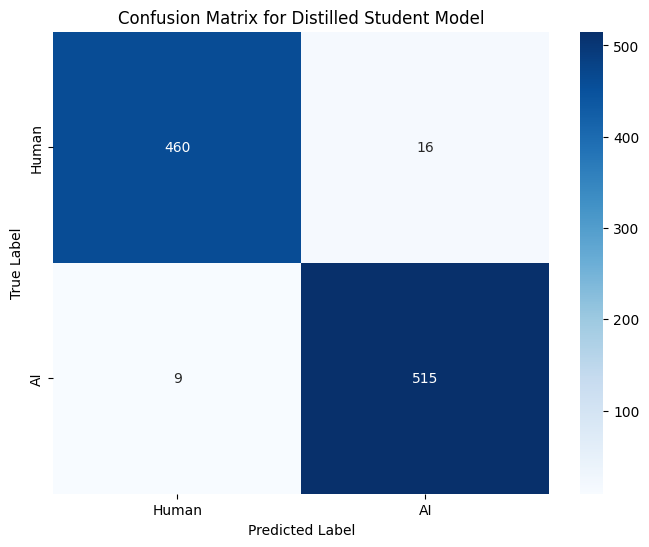

In [ ]:
# --- 1. Installation ---
import sys
!{sys.executable} -m pip install torch transformers scikit-learn pandas tqdm accelerate matplotlib seaborn sentencepiece

# --- 2. Imports ---
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Configuration ---
FILE_NAME = 'AI_Human_5k_balanced.csv'
TEXT_COLUMN = 'text'
LABEL_COLUMN = 'generated'
RANDOM_STATE = 42
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
TEACHER_DEBERTA = 'microsoft/deberta-base'
TEACHER_ELECTRA = 'google/electra-base-discriminator'
STUDENT_MODEL = 'distilbert-base-uncased'
MAX_LENGTH = 128

# --- 4. Load and Split Data ---
print("Loading and splitting data...")
df = pd.read_csv(FILE_NAME)
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=RANDOM_STATE)
print(f"Data split: {len(train_df)} train, {len(val_df)} validation, {len(test_df)} test.")

# --- 5. Define the Ensemble Teacher Model ---
class EnsembleTeacher(torch.nn.Module):
    def __init__(self, deberta_path, electra_path):
        super().__init__()
        self.deberta = AutoModelForSequenceClassification.from_pretrained(deberta_path)
        self.electra = AutoModelForSequenceClassification.from_pretrained(electra_path)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            deberta_logits = self.deberta(input_ids, attention_mask=attention_mask).logits
            electra_logits = self.electra(input_ids, attention_mask=attention_mask).logits
        avg_logits = (deberta_logits + electra_logits) / 2
        return avg_logits

# --- 6. Set up Models and Tokenizers ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Loading teacher models...")
teacher_model = EnsembleTeacher(TEACHER_DEBERTA, TEACHER_ELECTRA)
teacher_model.to(device)
teacher_model.eval()
print("Loading student model...")
student_model = AutoModelForSequenceClassification.from_pretrained(STUDENT_MODEL, num_labels=2)
student_model.to(device)
teacher_tokenizer = AutoTokenizer.from_pretrained(TEACHER_ELECTRA)
student_tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL)

# --- 7. Create DataLoaders ---
def create_dataloader(df, tokenizer):
    encodings = tokenizer(df[TEXT_COLUMN].tolist(), truncation=True, padding=True, max_length=MAX_LENGTH)
    input_ids = torch.tensor(encodings['input_ids'])
    attention_mask = torch.tensor(encodings['attention_mask'])
    labels = torch.tensor(df[LABEL_COLUMN].tolist(), dtype=torch.long)
    dataset = TensorDataset(input_ids, attention_mask, labels)
    return DataLoader(dataset, batch_size=BATCH_SIZE)

train_dataloader = create_dataloader(train_df, student_tokenizer)
val_dataloader = create_dataloader(val_df, student_tokenizer)
test_dataloader = create_dataloader(test_df, student_tokenizer)
print("DataLoaders created.")

# --- 8. Distillation Training ---
optimizer = AdamW(student_model.parameters(), lr=LEARNING_RATE)
distillation_temp = 2.0
alpha = 0.5
history = {'train_loss': [], 'val_loss': []}

print("Starting knowledge distillation training...")
for epoch in range(EPOCHS):
    student_model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Training]")
    for batch in progress_bar:
        b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)
        teacher_logits = teacher_model(b_input_ids, b_attention_mask)
        student_outputs = student_model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        student_logits = student_outputs.logits
        student_loss = student_outputs.loss
        distillation_loss = F.kl_div(
            F.log_softmax(student_logits / distillation_temp, dim=-1),
            F.softmax(teacher_logits / distillation_temp, dim=-1),
            reduction='batchmean'
        ) * (distillation_temp ** 2)
        loss = alpha * student_loss + (1 - alpha) * distillation_loss
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.set_postfix({'loss': '{:.3f}'.format(loss.item())})

    avg_train_loss = total_train_loss / len(train_dataloader)
    history['train_loss'].append(avg_train_loss)

    student_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS} [Validation]"):
            b_input_ids, b_attention_mask, b_labels = tuple(t.to(device) for t in batch)
            outputs = student_model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    history['val_loss'].append(avg_val_loss)
    print(f"Epoch {epoch + 1} - Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

# --- 9. Evaluate the Student Model ---
print("\nEvaluating distilled student model on the test set...")
student_model.eval()
all_preds, all_true = [], []
for batch in tqdm(test_dataloader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_attention_mask, b_labels = batch
    with torch.no_grad():
        outputs = student_model(b_input_ids, attention_mask=b_attention_mask)
    logits = outputs.logits
    preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
    all_preds.extend(preds)
    all_true.extend(b_labels.detach().cpu().numpy())

print("\n--- Final Results for Distilled Student Model ---")
target_names = ['Human', 'AI']
print(classification_report(all_true, all_preds, target_names=target_names))
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Distilled Student Model')
plt.show()

# --- 10. Plot Training and Validation Loss ---
epochs_ran = len(history['train_loss'])
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_ran + 1), history['train_loss'], label='Training Loss')
plt.plot(range(1, epochs_ran + 1), history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()